In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, roc_auc_score, RocCurveDisplay, brier_score_loss, precision_score, recall_score, f1_score
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import optuna
import xgboost as xgb
import shap
from copy import deepcopy


c:\Users\CPN\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# 1. Đọc dữ liệu và tạo flag missing
df = pd.read_excel("hmeq.xlsx", engine="openpyxl")
df.drop(columns=['gDEBTINC'], inplace=True)
miss_vars = ['DEBTINC', 'VALUE', 'DEROG', 'JOB', 'DELINQ', 'YOJ', 'NINQ', 'CLAGE']
for var in miss_vars:
    df[f"{var}_missing"] = df[var].isna().astype(int)
cat_vars = ['REASON', 'JOB']
for var in cat_vars:
    df[var] = df[var].astype('category')


c:\Users\CPN\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [3]:

# 2. Khai báo biến
target = 'BAD'
all_features = [c for c in df.columns if c != target]


In [4]:

# 3. Split dữ liệu
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[target])
X = train_df[all_features]
y = train_df[target]


In [5]:

# 4. Định nghĩa pipeline builder
def build_pipeline(features, params):
    return xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        tree_method='hist',
        use_label_encoder=False,
        **params
    )


Selected features: ['REASON', 'JOB', 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC', 'DEBTINC_missing', 'VALUE_missing', 'DEROG_missing', 'JOB_missing', 'DELINQ_missing', 'YOJ_missing', 'NINQ_missing', 'CLAGE_missing']
Best CV logloss: 0.1905


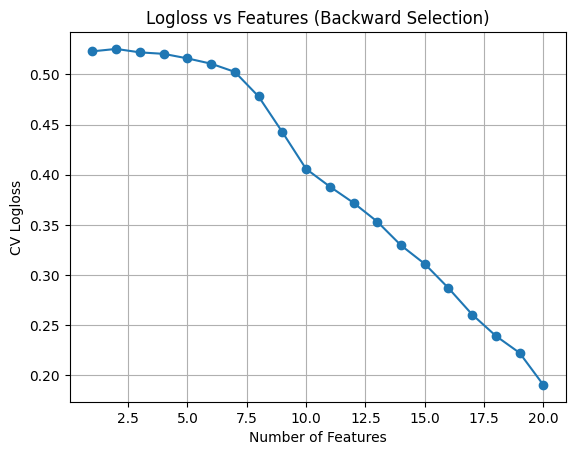

In [6]:

# 5. Backward Feature Selection
kf = KFold(n_splits=5, shuffle=True, random_state=42)
history = []
params_default = {'random_state':42, 'n_jobs':-1, 'verbosity':0}

def evaluate(features):
    X_sub = X[features].copy()
    for var in cat_vars:
        if var in features:
            X_sub[var] = X_sub[var].cat.codes
    pipe = build_pipeline(features, params_default)
    scores = cross_val_score(pipe, X_sub, y, cv=kf, scoring='neg_log_loss')
    return -scores.mean()

# Đánh giá full model với logloss
default_loss = evaluate(all_features)
history.append((deepcopy(all_features), default_loss))
features = deepcopy(all_features)

while len(features) > 1:
    scores = {}
    for feat in features:
        subset = [f for f in features if f != feat]
        scores[feat] = evaluate(subset)
    worst = max(scores, key=scores.get)
    features.remove(worst)
    history.append((features.copy(), scores[worst]))

# Chọn best_feats theo logloss nhỏ nhất
best_feats, best_loss = min(history, key=lambda x: x[1])
print(f"Selected features: {best_feats}\nBest CV logloss: {best_loss:.4f}")

# Plot logloss vs số features
df_loss = pd.DataFrame({'n_features':[len(f) for f,_ in history], 'logloss':[l for _,l in history]})
plt.plot(df_loss['n_features'], df_loss['logloss'], marker='o')
plt.xlabel('Number of Features')
plt.ylabel('CV Logloss')
plt.title('Logloss vs Features (Backward Selection)')
plt.grid(True)
plt.show()


In [8]:

# 6. Tune Optuna và train trên best_feats
direction = 'minimize'
optuna.logging.set_verbosity(optuna.logging.INFO)
study = optuna.create_study(direction=direction)

def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10, log=True),
        'lambda': trial.suggest_float('lambda', 1e-3, 10, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10, log=True),
    }
    X_sub = X[best_feats].copy()
    for var in cat_vars:
        if var in best_feats:
            X_sub[var] = X_sub[var].cat.codes
    dtrain = xgb.DMatrix(X_sub, label=y)
    cv = xgb.cv(
        params={**params, 'objective':'binary:logistic','eval_metric':'logloss','tree_method':'hist'},
        dtrain=dtrain,
        num_boost_round=1000,
        nfold=5,
        early_stopping_rounds=50,
        seed=42,
        metrics=('logloss'),
        as_pandas=True
    )
    trial.set_user_attr('best_iteration', len(cv))
    return cv['test-logloss-mean'].min()

study.optimize(objective, n_trials=100)
best_params = study.best_params
best_params.update({'objective':'binary:logistic','eval_metric':'logloss','tree_method':'hist'})


[I 2025-06-20 15:48:50,245] A new study created in memory with name: no-name-c96fa934-5079-46a4-8160-39df6a37963c
[I 2025-06-20 15:49:10,543] Trial 0 finished with value: 0.1834005251095578 and parameters: {'learning_rate': 0.022903207688465158, 'max_depth': 9, 'subsample': 0.6674354823813894, 'colsample_bytree': 0.6270460456985976, 'min_child_weight': 0.6830173365104051, 'lambda': 9.409660652957038, 'alpha': 0.0019102230143606374}. Best is trial 0 with value: 0.1834005251095578.
[I 2025-06-20 15:49:14,028] Trial 1 finished with value: 0.18325809476457083 and parameters: {'learning_rate': 0.24727222249232636, 'max_depth': 7, 'subsample': 0.983538273792655, 'colsample_bytree': 0.7808207173886064, 'min_child_weight': 1.2915500504538142, 'lambda': 9.95906135908917, 'alpha': 0.0024237318252200023}. Best is trial 1 with value: 0.18325809476457083.
[I 2025-06-20 15:49:27,532] Trial 2 finished with value: 0.21300598414145516 and parameters: {'learning_rate': 0.03510310786618888, 'max_depth': 

Confusion Matrix:
 [[925  29]
 [ 73 165]]
Precision: 0.8505
Recall:    0.6933
F1 Score:  0.7639
Test ROC AUC: 0.9594


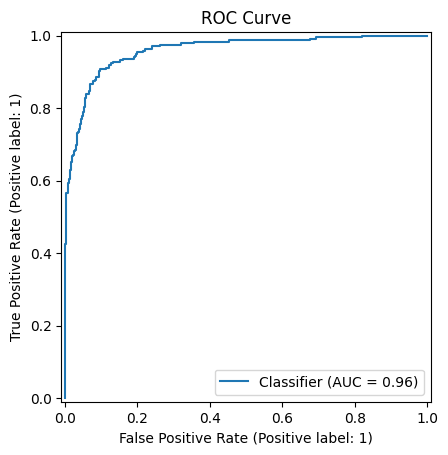

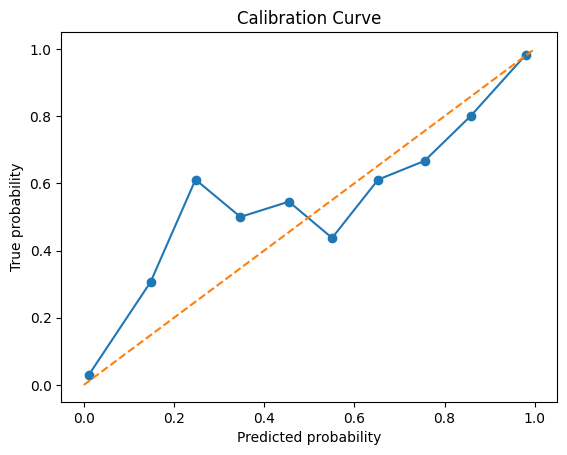

Brier score: 0.0599


In [9]:

# 7. Train final và đánh giá trên test
dtrain_full = xgb.DMatrix(train_df[best_feats], label=train_df[target], enable_categorical=True)
dtest = xgb.DMatrix(test_df[best_feats], enable_categorical=True)
model = xgb.train(
    params=best_params,
    dtrain=dtrain_full,
    num_boost_round=study.user_attrs.get('best_iteration',1000)
)

y_pred_prob = model.predict(dtest)
y_pred = (y_pred_prob >= 0.5).astype(int)
print("Confusion Matrix:\n", confusion_matrix(test_df[target], y_pred))
print(f"Precision: {precision_score(test_df[target], y_pred):.4f}")
print(f"Recall:    {recall_score(test_df[target], y_pred):.4f}")
print(f"F1 Score:  {f1_score(test_df[target], y_pred):.4f}")
print(f"Test ROC AUC: {roc_auc_score(test_df[target], y_pred_prob):.4f}")
RocCurveDisplay.from_predictions(test_df[target], y_pred_prob)
plt.title('ROC Curve')
plt.show()
prob_true, prob_pred = calibration_curve(test_df[target], y_pred_prob, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1],linestyle='--')
plt.xlabel('Predicted probability')
plt.ylabel('True probability')
plt.title('Calibration Curve')
plt.show()
print(f"Brier score: {brier_score_loss(test_df[target], y_pred_prob):.4f}")


C:\Users\CPN\AppData\Local\Temp\ipykernel_16304\1645071881.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, test_df[best_feats])


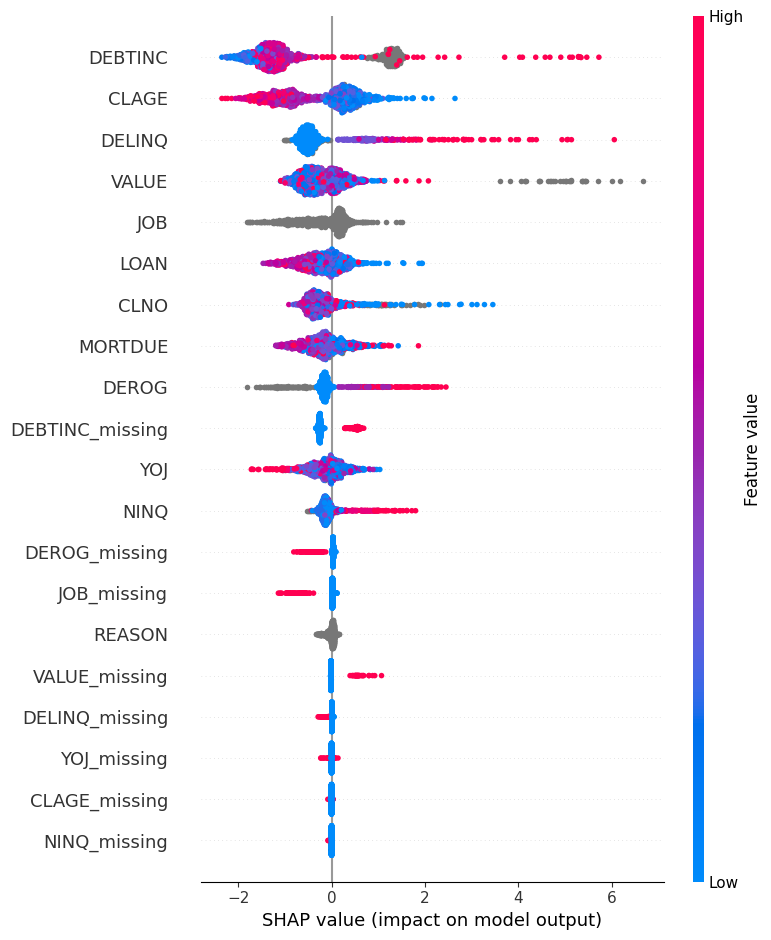

<Figure size 640x480 with 0 Axes>

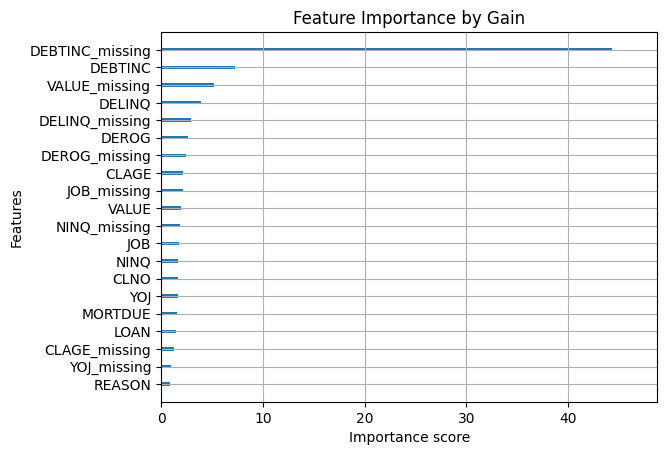

In [10]:

# 8. SHAP & Feature importance
dtest_shap = xgb.DMatrix(test_df[best_feats], enable_categorical=True)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(dtest_shap)
shap.summary_plot(shap_values, test_df[best_feats])
plt.figure()
xgb.plot_importance(model, importance_type='gain', show_values=False)
plt.title('Feature Importance by Gain')
plt.show()
